In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from obp.ope import ReplayMethod
from obp.policy import EpsilonGreedy
from sd_bandits.obp_extensions.policy import ExploreThenCommit, SegmentPolicy 

from sd_bandits.obp_extensions.dataset import DeezerDataset

# Load Deezer Data

In [2]:
user_features_path = "../data/deezer_carousel_bandits/user_features.csv"
playlist_features_path = "../data/deezer_carousel_bandits/playlist_features.csv"

deezer_data = DeezerDataset(
    user_features_path,
    playlist_features_path,
    len_list=12,
    len_init=3,
)

# Get policy feedback

## Random policy

In [3]:
random_deezer_feedback = deezer_data.obtain_batch_bandit_feedback(
    n_batches=100,
    users_per_batch=1000,
    cascade=True,
    seed=1,
)

Generating feedback: 100%|██████████| 100000/100000 [00:03<00:00, 27930.86it/s]


## Epsilon greedy (segmented and unsegmented)

In [4]:
e_greedy = EpsilonGreedy(
    n_actions=deezer_data.n_actions,
    len_list=12,
    # this batch_size setting will be ignored because supplying the policy
    # to `deezer_data.obtain_batch_bandit_feedback` will manually update
    # once per batch of *users*
    batch_size=1,
    random_state=1,
    epsilon=0.1,
    policy_name="e_greedy_explore",
)

e_greedy_seg = SegmentPolicy(
    EpsilonGreedy(
        n_actions=deezer_data.n_actions,
        len_list=12,
        # this batch_size setting will be ignored because supplying the policy
        # to `deezer_data.obtain_batch_bandit_feedback` will manually update
        # once per batch of *users*
        batch_size=1,
        random_state=1,
        epsilon=0.1,
        policy_name="e_greedy_explore",
    ),
    n_segments=100,
)

e_greedy_feedback = deezer_data.obtain_batch_bandit_feedback(
    policy=e_greedy, n_batches=100, users_per_batch=1000, cascade=True, seed=1
)


e_greedy_seg_feedback = deezer_data.obtain_batch_bandit_feedback(
    policy=e_greedy_seg, n_batches=100, users_per_batch=1000, cascade=True, seed=1
)

Simulating online learning: 100%|██████████| 100000/100000 [00:24<00:00, 4066.49it/s]


# Realign the data to plot by batch instead of round

All of these datasets have the same users, but each user is being shown different actions and, thus, due to the cascade effect the number of observed rewards will be different.

We group the rewards by batch so that all plots have the same x-axis.

In [5]:
random = pd.DataFrame(
    dict(
        reward=random_deezer_feedback["reward"],
        batch=random_deezer_feedback["batches"],
        pol="random",
    )
)
eps = pd.DataFrame(
    dict(
        reward=e_greedy_feedback["reward"],
        batch=e_greedy_feedback["batches"],
        pol="eps",
    )
)
eps_seg = pd.DataFrame(
    dict(
        reward=e_greedy_seg_feedback["reward"],
        batch=e_greedy_seg_feedback["batches"],
        pol="eps_seg",
    )
)

Text(0, 0.5, 'cumulative rewards')

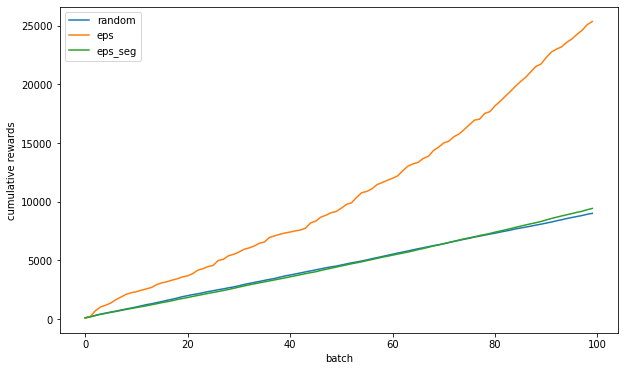

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(random.groupby("batch").sum().cumsum(), label="random")
ax.plot(eps.groupby("batch").sum().cumsum(), label="eps")
ax.plot(eps_seg.groupby("batch").sum().cumsum(), label="eps_seg")
ax.legend()
ax.set_xlabel("batch")
ax.set_ylabel("cumulative rewards")